In [1]:
import matplotlib
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format='retina'
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 12, 8

In [2]:
!pip install -U nltk
!python -m nltk.downloader 'popular'

Requirement already up-to-date: nltk in /usr/local/lib/python3.7/dist-packages (3.5)
/usr/lib/python3.7/runpy.py:125: RuntimeWarning: 'nltk.downloader' found in sys.modules after import of package 'nltk', but prior to execution of 'nltk.downloader'; this may result in unpredictable behaviour
  warn(RuntimeWarning(msg))
[nltk_data] Downloading collection 'popular'
[nltk_data]    | 
[nltk_data]    | Downloading package cmudict to /root/nltk_data...
[nltk_data]    |   Package cmudict is already up-to-date!
[nltk_data]    | Downloading package gazetteers to /root/nltk_data...
[nltk_data]    |   Package gazetteers is already up-to-date!
[nltk_data]    | Downloading package genesis to /root/nltk_data...
[nltk_data]    |   Package genesis is already up-to-date!
[nltk_data]    | Downloading package gutenberg to /root/nltk_data...
[nltk_data]    |   Package gutenberg is already up-to-date!
[nltk_data]    | Downloading package inaugural to /root/nltk_data...
[nltk_data]    |   Package inaugural 

In [3]:
!pip install -U wn==0.0.23

Requirement already up-to-date: wn==0.0.23 in /usr/local/lib/python3.7/dist-packages (0.0.23)


In [4]:
!pip install transformers

In [5]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
import torch
import transformers as ppb
import warnings
warnings.filterwarnings('ignore')

In [6]:
!wget https://raw.githubusercontent.com/devkosal/fastai_roberta/master/fastai_roberta_imdb/imdb_dataset.csv


--2021-04-01 11:56:52--  https://raw.githubusercontent.com/devkosal/fastai_roberta/master/fastai_roberta_imdb/imdb_dataset.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 66212309 (63M) [text/plain]
Saving to: ‘imdb_dataset.csv.13’

imdb_dataset.csv.13 100%[===================>]  63.14M  63.0MB/s    in 1.0s    

2021-04-01 11:56:53 (63.0 MB/s) - ‘imdb_dataset.csv.13’ saved [66212309/66212309]



Задача: определение тональности отзыва на IMDB

In [7]:
df = pd.read_csv('imdb_dataset.csv')

In [8]:
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [9]:
sent_index = []
for sent in df['sentiment']:
  if sent == 'positive':
    sent_index.append(1)
  else:
    sent_index.append(0)
df['sentiment_index'] = sent_index

In [10]:
rev_trimmed = []
for rev in df['review']:
  rev_trimmed.append(rev[:500])

df['review_trimmed'] = rev_trimmed

In [11]:
df

,review,sentiment,sentiment_index,review_trimmed
0,One of the other reviewers has mentioned that ...,positive,1,One of the other reviewers has mentioned that ...
1,A wonderful little production. <br /><br />The...,positive,1,A wonderful little production. <br /><br />The...
2,I thought this was a wonderful way to spend ti...,positive,1,I thought this was a wonderful way to spend ti...
3,Basically there's a family where a little boy ...,negative,0,Basically there's a family where a little boy ...
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,1,"Petter Mattei's ""Love in the Time of Money"" is..."
...,...,...,...,...
49995,I thought this movie did a down right good job...,positive,1,I thought this movie did a down right good job...
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",negative,0,"Bad plot, bad dialogue, bad acting, idiotic di..."
49997,I am a Catholic taught in parochial elementary...,negative,0,I am a Catholic taught in parochial elementary...
49998,I'm going to have to disagree with the previou...,negative,0,I'm going to have to disagree with the previou...


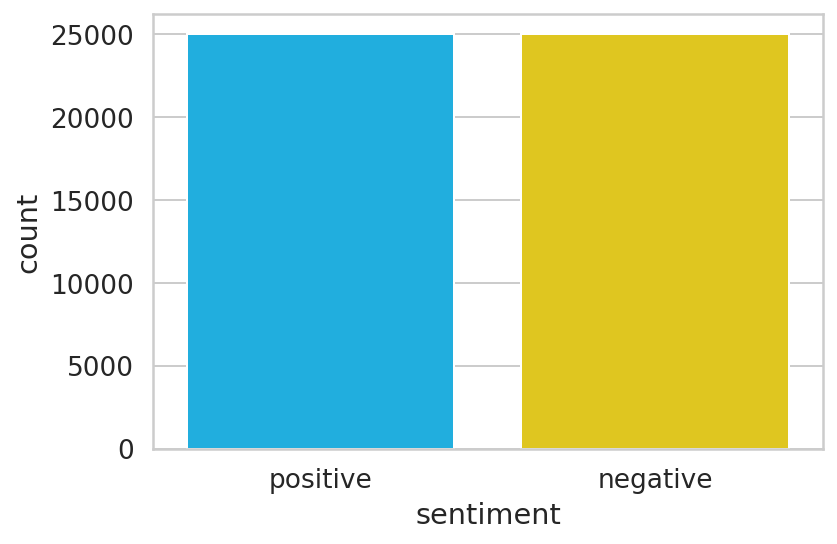

In [12]:
sns.countplot(df.sentiment)
plt.xlabel('sentiment');

Распределение между положительными и отрицательными отзывами равномерное.

In [13]:
!pip install pyspellchecker

from spellchecker import SpellChecker

spell = SpellChecker(language='en')

# Тренировка DistilBERT'а

In [14]:
model_class, tokenizer_class, pretrained_weights = (ppb.DistilBertModel, ppb.DistilBertTokenizer, 'distilbert-base-uncased')
tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
model = model_class.from_pretrained(pretrained_weights)

In [15]:
import nltk
import re

def text_preprocessing(s):

    s = s.lower()
    s = re.sub(r"n\'t", " not", s)
    s = re.sub(r'([\'\"\.\(\)\!\?\\\/\,])', r' \1 ', s)
    s = re.sub(r'[^\w\s\?]', ' ', s)
    s = re.sub(r'([\;\:\|•«\n])', ' ', s)
    s = re.sub(r'\s+', ' ', s).strip()

    return s

In [16]:
text_preprocessing("Do it, man!")

'do it man'

In [17]:
batch_1 = df[:500]

batch_1['review_trimmed_processed'] = [text_preprocessing(t) for t in batch_1['review_trimmed']]

tokenized = pd.Series(batch_1['review_trimmed_processed']).apply(lambda x: tokenizer.encode(x, add_special_tokens=True))

In [18]:
len(tokenizer.decode(tokenized[0]))


491

In [19]:
tokenizer.vocab['[CLS]']


101

In [20]:
max_len = 0
for i in tokenized.values:
    if len(i) > max_len:
        max_len = len(i)

padded = np.array([i + [0]*(max_len-len(i)) for i in tokenized.values])

In [21]:
np.array(padded).shape


(500, 120)

In [22]:
padded[0]


array([  101,  2028,  1997,  1996,  2060, 15814,  2038,  3855,  2008,
        2044,  3666,  2074,  1015, 11472,  2792,  2017,  2222,  2022,
       13322,  2027,  2024,  2157,  2004,  2023,  2003,  3599,  2054,
        3047,  2007,  2033,  7987,  7987,  1996,  2034,  2518,  2008,
        4930,  2033,  2055, 11472,  2001,  2049, 24083,  1998,  4895,
       10258,  2378,  8450,  5019,  1997,  4808,  2029,  2275,  1999,
        2157,  2013,  1996,  2773,  2175,  3404,  2033,  2023,  2003,
        2025,  1037,  2265,  2005,  1996,  8143, 18627,  2030,  5199,
        3593,  2023,  2265,  8005,  2053, 17957,  2007, 12362,  2000,
        5850,  3348,  2030,  4808,  2049,  2003, 13076,  1999,  1996,
        4438,  2224,  1997,  1996,  2773,  7987,  7987,  2009,  2003,
        2170, 11472,   102,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0])

In [23]:
tokenizer.ids_to_tokens[0]


'[PAD]'

## Создаём маску

In [24]:
attention_mask = np.where(padded != 0, 1, 0)
attention_mask.shape

(500, 120)

In [25]:
len(tokenized[0])


102

In [26]:
attention_mask[0]

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [27]:
input_ids = torch.tensor(padded)  
attention_mask = torch.tensor(attention_mask)

with torch.no_grad():
    last_hidden_states = model(input_ids, attention_mask=attention_mask)

In [28]:
last_hidden_states[0][0]


tensor([[ 8.6995e-02, -2.4743e-01,  7.1603e-03,  ..., -1.5252e-01,
          4.2874e-01,  1.8420e-01],
        [-2.7107e-01, -2.1655e-01, -1.1418e-01,  ...,  2.2491e-02,
          1.8939e-01,  1.2371e-01],
        [-5.7565e-01, -1.5535e-01, -1.7763e-01,  ...,  2.5025e-02,
         -1.7114e-02,  1.1941e-03],
        ...,
        [ 2.5866e-01,  5.3723e-02,  2.3259e-01,  ...,  3.6806e-04,
          1.5932e-01,  1.1726e-01],
        [ 2.8045e-01,  3.2519e-02,  7.8765e-02,  ...,  7.2685e-02,
          1.0934e-01,  2.3993e-02],
        [ 9.5783e-02,  6.3704e-02,  6.6867e-02,  ...,  2.9128e-02,
         -2.3283e-02, -2.7626e-01]])

In [29]:
features = last_hidden_states[0][:,0,:].numpy()
labels = batch_1['sentiment_index']


# Тренировка BERT'а

In [30]:
model_class_b, tokenizer_class_b, pretrained_weights_b = (ppb.BertModel, ppb.BertTokenizer, 'bert-base-uncased')

tokenizer_b = tokenizer_class.from_pretrained(pretrained_weights_b)
model_b = model_class_b.from_pretrained(pretrained_weights_b)


In [31]:
tokenized_b = pd.Series(batch_1['review_trimmed_processed']).apply(lambda x: tokenizer_b.encode(x, add_special_tokens=True))

In [32]:
tokenizer_b.decode(tokenized[0])


'[CLS] one of the other reviewers has mentioned that after watching just 1 oz episode you ll be hooked they are right as this is exactly what happened with me br br the first thing that struck me about oz was its brutality and unflinching scenes of violence which set in right from the word go trust me this is not a show for the faint hearted or timid this show pulls no punches with regards to drugs sex or violence its is hardcore in the classic use of the word br br it is called oz [SEP]'

In [33]:
tokenizer_b.vocab['[CLS]']


101

In [34]:
max_len = 0
for i in tokenized_b.values:
    if len(i) > max_len:
        max_len = len(i)

padded_b = np.array([i + [0]*(max_len-len(i)) for i in tokenized_b.values])

In [35]:
np.array(padded_b).shape


(500, 120)

In [36]:
padded_b[0]


array([  101,  2028,  1997,  1996,  2060, 15814,  2038,  3855,  2008,
        2044,  3666,  2074,  1015, 11472,  2792,  2017,  2222,  2022,
       13322,  2027,  2024,  2157,  2004,  2023,  2003,  3599,  2054,
        3047,  2007,  2033,  7987,  7987,  1996,  2034,  2518,  2008,
        4930,  2033,  2055, 11472,  2001,  2049, 24083,  1998,  4895,
       10258,  2378,  8450,  5019,  1997,  4808,  2029,  2275,  1999,
        2157,  2013,  1996,  2773,  2175,  3404,  2033,  2023,  2003,
        2025,  1037,  2265,  2005,  1996,  8143, 18627,  2030,  5199,
        3593,  2023,  2265,  8005,  2053, 17957,  2007, 12362,  2000,
        5850,  3348,  2030,  4808,  2049,  2003, 13076,  1999,  1996,
        4438,  2224,  1997,  1996,  2773,  7987,  7987,  2009,  2003,
        2170, 11472,   102,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0])

In [37]:
tokenizer_b.ids_to_tokens[0]


'[PAD]'

## Создаём маску

In [38]:
attention_mask_b = np.where(padded_b != 0, 1, 0)
attention_mask_b.shape

(500, 120)

In [39]:
len(tokenized_b[0])


102

In [40]:
attention_mask_b[0]

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [41]:
input_ids_b = torch.tensor(padded_b)  
attention_mask_b = torch.tensor(attention_mask_b)

with torch.no_grad():
    last_hidden_states_b = model(input_ids_b, attention_mask=attention_mask_b)

In [42]:
last_hidden_states_b[0][0]


tensor([[ 8.6995e-02, -2.4743e-01,  7.1603e-03,  ..., -1.5252e-01,
          4.2874e-01,  1.8420e-01],
        [-2.7107e-01, -2.1655e-01, -1.1418e-01,  ...,  2.2491e-02,
          1.8939e-01,  1.2371e-01],
        [-5.7565e-01, -1.5535e-01, -1.7763e-01,  ...,  2.5025e-02,
         -1.7114e-02,  1.1941e-03],
        ...,
        [ 2.5866e-01,  5.3723e-02,  2.3259e-01,  ...,  3.6806e-04,
          1.5932e-01,  1.1726e-01],
        [ 2.8045e-01,  3.2519e-02,  7.8765e-02,  ...,  7.2685e-02,
          1.0934e-01,  2.3993e-02],
        [ 9.5783e-02,  6.3704e-02,  6.6867e-02,  ...,  2.9128e-02,
         -2.3283e-02, -2.7626e-01]])

In [43]:
features_b = last_hidden_states_b[0][:,0,:].numpy()
labels_b = batch_1['sentiment_index']


# Подготовка модели (BERT и не-BERT)

In [44]:
train_features, test_features, train_labels, test_labels = train_test_split(features, labels)

In [45]:
train_features_b, test_features_b, train_labels_b, test_labels_b = train_test_split(features_b, labels_b)

In [46]:
SEED = 227
np.random.seed(SEED)
df_train_no_bert, df_test_no_bert = train_test_split(batch_1, 
                                                     train_size=0.5, 
                                                     test_size=0.5, 
                                                     stratify=batch_1.sentiment_index, 
                                                     random_state=SEED)


In [47]:
y_train_no_bert = df_train_no_bert.sentiment_index
y_test_no_bert = df_test_no_bert.sentiment_index

In [48]:
from sklearn.metrics import f1_score, classification_report, accuracy_score

## 1) Логистическая регрессия (DistilBert)

In [49]:
lr_clf = LogisticRegression()
lr_clf.fit(train_features, train_labels)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [50]:


pred_labels = lr_clf.predict(test_features)
print(classification_report(test_labels, pred_labels))
print(f'Accuracy: {accuracy_score(pred_labels, test_labels)}')

              precision    recall  f1-score   support

           0       0.79      0.81      0.80        67
           1       0.77      0.76      0.77        58

    accuracy                           0.78       125
   macro avg       0.78      0.78      0.78       125
weighted avg       0.78      0.78      0.78       125

Accuracy: 0.784


## 2) Логистическая регрессия + gridsearch (DistilBert)

In [51]:
from sklearn.model_selection import GridSearchCV

params = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000] }

lr_clf_2 = GridSearchCV(LogisticRegression(), 
                    params,
                    scoring='accuracy',
                    verbose=True)

lr_clf_2.fit(train_features, train_labels)

Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  35 out of  35 | elapsed:    2.4s finished


GridSearchCV(cv=None, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='accuracy', verbose=True)

In [52]:
pred_labels = lr_clf_2.predict(test_features)
print(classification_report(test_labels, pred_labels))
print(f'Accuracy: {accuracy_score(pred_labels, test_labels)}')

              precision    recall  f1-score   support

           0       0.79      0.79      0.79        67
           1       0.76      0.76      0.76        58

    accuracy                           0.78       125
   macro avg       0.77      0.77      0.77       125
weighted avg       0.78      0.78      0.78       125

Accuracy: 0.776


## 3) Логистическая регрессия (BERT)

In [53]:
lr_clf_b = LogisticRegression()
lr_clf_b.fit(train_features_b, train_labels_b)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [54]:
pred_labels = lr_clf_b.predict(test_features_b)

print(classification_report(test_labels_b, pred_labels))

print(f'Accuracy: {accuracy_score(pred_labels, test_labels_b)}')


              precision    recall  f1-score   support

           0       0.80      0.76      0.78        62
           1       0.77      0.81      0.79        63

    accuracy                           0.78       125
   macro avg       0.78      0.78      0.78       125
weighted avg       0.78      0.78      0.78       125

Accuracy: 0.784


## 4) Логистическая регрессия + gridsearch (BERT)

In [55]:
from sklearn.model_selection import GridSearchCV

params = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000] }

lr_clf_2 = GridSearchCV(LogisticRegression(), 
                    params,
                    scoring='accuracy',
                    verbose=True)

lr_clf_2.fit(train_features_b, train_labels_b)


Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  35 out of  35 | elapsed:    2.3s finished


GridSearchCV(cv=None, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='accuracy', verbose=True)

In [56]:
pred_labels = lr_clf_2.predict(test_features_b)

print(classification_report(test_labels_b, pred_labels))

print(f'Accuracy: {accuracy_score(pred_labels, test_labels_b)}')


              precision    recall  f1-score   support

           0       0.80      0.76      0.78        62
           1       0.77      0.81      0.79        63

    accuracy                           0.78       125
   macro avg       0.78      0.78      0.78       125
weighted avg       0.78      0.78      0.78       125

Accuracy: 0.784


# Сверяем модели БЕЗ BERT'а

## 1) Без BERT-а; CountVectorizer

In [57]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, HashingVectorizer, TfidfTransformer

In [58]:
%%time

from sklearn.naive_bayes import *

count_vectorizer = CountVectorizer()
X_train_count = count_vectorizer.fit_transform(df_train_no_bert.review_trimmed_processed)
X_test_count = count_vectorizer.transform(df_test_no_bert.review_trimmed_processed)
X_train = X_train_count
X_test = X_test_count

tf_idf = CountVectorizer(ngram_range=(1, 3),
                         binary=True)
X_train_tfidf = tf_idf.fit_transform(df_train_no_bert)
X_test_tfidf = tf_idf.transform(df_test_no_bert)

CPU times: user 72.5 ms, sys: 53.7 ms, total: 126 ms
Wall time: 79.6 ms


In [59]:
model = MultinomialNB()
model.fit(X_train, y_train_no_bert)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [60]:
y_pred = model.predict(X_test)
print(classification_report(y_test_no_bert, y_pred))
print(f'Accuracy: {accuracy_score(y_pred, y_test_no_bert)}')

              precision    recall  f1-score   support

           0       0.66      0.84      0.74       132
           1       0.74      0.52      0.61       118

    accuracy                           0.69       250
   macro avg       0.70      0.68      0.68       250
weighted avg       0.70      0.69      0.68       250

Accuracy: 0.688


## 2) Без BERT-а; TfidfVectorizer по словам + Logistic Regression

In [61]:
%%time
tfidf_vectorizer = TfidfVectorizer()
X_train_tfidf = tfidf_vectorizer.fit_transform(df_train_no_bert.review_trimmed_processed)
X_test_tfidf = tfidf_vectorizer.transform(df_test_no_bert.review_trimmed_processed)
X_train = X_train_tfidf
X_test = X_test_tfidf

CPU times: user 60.1 ms, sys: 1.01 ms, total: 61.2 ms
Wall time: 59.7 ms


In [62]:
%%time
model = LogisticRegression(random_state=SEED, solver='liblinear')
model.fit(X_train, y_train_no_bert)

CPU times: user 3.87 ms, sys: 0 ns, total: 3.87 ms
Wall time: 7 ms


In [63]:
y_pred = model.predict(X_test)
print(classification_report(y_test_no_bert, y_pred))
print(f'Accuracy: {accuracy_score(y_pred, y_test_no_bert)}')

              precision    recall  f1-score   support

           0       0.65      0.83      0.73       132
           1       0.72      0.49      0.59       118

    accuracy                           0.67       250
   macro avg       0.69      0.66      0.66       250
weighted avg       0.68      0.67      0.66       250

Accuracy: 0.672


## 3) TfidfVectorizer по 1-3 граммам слов + TfidfVectorizer по 3-4 граммам символов + LogisticRegression

In [64]:
%%time

from scipy.sparse import coo_matrix, hstack

tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 4))
X_train_tfidf = tfidf_vectorizer.fit_transform(df_train_no_bert.review_trimmed_processed)
X_test_tfidf = tfidf_vectorizer.transform(df_test_no_bert.review_trimmed_processed)

tfidf_vectorizer_char = TfidfVectorizer(ngram_range=(3, 4), analyzer='char')
X_train_tfidf_char = tfidf_vectorizer_char.fit_transform(df_train_no_bert.review_trimmed_processed)
X_test_tfidf_char = tfidf_vectorizer_char.transform(df_test_no_bert.review_trimmed_processed)

X_train = hstack((X_train_tfidf, X_train_tfidf_char))
X_test = hstack((X_test_tfidf, X_test_tfidf_char))

CPU times: user 829 ms, sys: 10.5 ms, total: 840 ms
Wall time: 854 ms


In [65]:
%%time
model = LogisticRegression(random_state=SEED, solver='liblinear')
model.fit(X_train, y_train_no_bert)

CPU times: user 57.1 ms, sys: 29.9 ms, total: 87 ms
Wall time: 57.5 ms


In [66]:
y_pred = model.predict(X_test)
print(classification_report(y_test_no_bert, y_pred))
print(f'Accuracy: {accuracy_score(y_pred, y_test_no_bert)}')

              precision    recall  f1-score   support

           0       0.66      0.85      0.74       132
           1       0.75      0.51      0.61       118

    accuracy                           0.69       250
   macro avg       0.70      0.68      0.67       250
weighted avg       0.70      0.69      0.68       250

Accuracy: 0.688


## 4) TfidfVectorizer + Spacy + Логическая регрессия

In [67]:
%%time
!python -m spacy download en_core_web_md
import spacy 
import en_core_web_md
nlp = en_core_web_md.load()

✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_md')
CPU times: user 20.7 s, sys: 692 ms, total: 21.4 s
Wall time: 25.7 s


In [68]:
%%time
from scipy.sparse.csr import csr_matrix
X_train_vectors = csr_matrix([nlp(twi_text).vector for twi_text in df_train_no_bert.review_trimmed_processed])
X_test_vectors = csr_matrix([nlp(twi_text).vector for twi_text in df_test_no_bert.review_trimmed_processed])
X_train = hstack((X_train_tfidf, X_train_tfidf_char, X_train_vectors))
X_test = hstack((X_test_tfidf, X_test_tfidf_char, X_test_vectors))

CPU times: user 12.9 s, sys: 78.9 ms, total: 13 s
Wall time: 13 s


In [69]:
%%time
model = LogisticRegression(random_state=SEED, solver='liblinear')
model.fit(X_train, y_train_no_bert)

CPU times: user 99.7 ms, sys: 45.9 ms, total: 146 ms
Wall time: 86.4 ms


In [70]:
y_pred = model.predict(X_test)
print(classification_report(y_test_no_bert, y_pred))
print(f'Accuracy: {accuracy_score(y_pred, y_test_no_bert)}')

              precision    recall  f1-score   support

           0       0.74      0.86      0.79       132
           1       0.80      0.66      0.73       118

    accuracy                           0.76       250
   macro avg       0.77      0.76      0.76       250
weighted avg       0.77      0.76      0.76       250

Accuracy: 0.764
